### Transcription factor proportion

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
# from scipy.stats import beta
# from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
# from collections import defaultdict
import scipy.stats as stats
from matplotlib.lines import Line2D

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

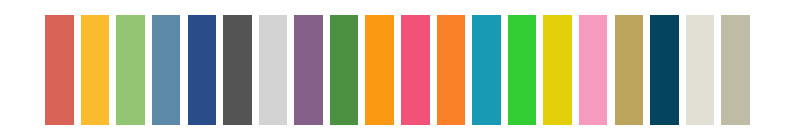

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [3]:
# load ella results
fn = '../ella/output_ella/ella_stereoseq_t1t20.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [4]:
# compute patttern strength
s_dict = {}
for t in types_list:
    lam_t = lam_dict[t]
    s_t = []
    for lam in lam_t:
        s = (np.max(lam)-np.min(lam))/np.max(lam)
        s_t.append(s)
    s_dict[t] = s_t

#### transcription factors

In [5]:
# TF genes
fn = 'input/Browse Transcription Factors mm9 - resource_browser.csv'
tab = pd.read_csv(fn)
tf_list = tab.Symbol.unique().tolist()
print(f'total #TF {len(tf_list)}')

list1_lower = [item.lower() for item in tf_list]
list2_lower = [item.lower() for item in np.concatenate(list(genes_dict.values()), axis=0)]
seqfish_TFs = set(list1_lower).intersection(set(list2_lower))
print(f'included #TF {len(seqfish_TFs)}')

for t in types_list:
    list1_lower = [item.lower() for item in tf_list]
    list2_lower = [item.lower() for item in np.array(genes_dict[t])[p_fdr_dict[t]<=0.05]]
    seqfish_TFs_sig = set(list1_lower).intersection(set(list2_lower))
    print(f'sig #TF {len(seqfish_TFs_sig)}')

total #TF 1385
included #TF 146
sig #TF 39
sig #TF 28


In [6]:
# TF included
tf_dict = {}
for t in types_list:
    gl_t = genes_dict[t]
    tf_dict[t] = list(set(gl_t).intersection(tf_list))
    print(f'#TF avl in {t} {len(tf_dict[t])}')

#TF avl in 1 108
#TF avl in 20 124


In [7]:
# get pv, scores, labels of included TFs genes
tf_gene_list_dict = {}
tf_pv_fdr_dict = {}
tf_scores_dict = {}
tf_labels_dict = {}
tf_s_dict = {}
for t in types_list:
    tf_t = np.array(tf_dict[t])
    gl_t = np.array(genes_dict[t])
    pv_fdr_t = np.array(p_fdr_dict[t])
    scores_t = np.array(score_dict[t])
    labels_t = np.array(label_dict[t])
    s_t = s_dict[t]
    tf_pv_fdr_t = []
    tf_scores_t = []
    tf_labels_t = []
    tf_s_t = []
    for ig, g in enumerate(tf_t):
        idx = np.where(gl_t == g)[0][0]
        tf_pv_fdr_t.append(pv_fdr_t[idx])
        tf_scores_t.append(scores_t[idx])
        tf_labels_t.append(labels_t[idx])
        tf_s_t.append(s_t[idx])
    tf_pv_fdr_dict[t] = tf_pv_fdr_t
    tf_scores_dict[t] = tf_scores_t
    tf_labels_dict[t] = tf_labels_t
    tf_s_dict[t] = tf_s_t
    nsig_ = np.sum(np.array(tf_pv_fdr_t)<=0.05)

In [8]:
# tf proportion in each cluster
tf_label_all = np.concatenate([lst for lst in tf_labels_dict.values()])
tf_score_all = np.concatenate([lst for lst in tf_scores_dict.values()])
tf_s_all = np.concatenate([lst for lst in tf_s_dict.values()])
label_all = np.concatenate([lst for lst in label_dict.values()])

tf_prop_list = []
tf_num_list = []

for k in [0,1,2,3,4,-1]:
    tf_prop = np.sum(np.array(tf_label_all)==k)/np.sum(label_all==k)
    tf_prop_list.append(tf_prop)
    tf_num_list.append(np.sum(np.array(tf_label_all)==k))
    print(f'k={k} %TF={tf_prop*100:.2f}% mean(s)={np.mean(tf_s_all[tf_label_all==k])}')

k=0 %TF=17.86% mean(s)=0.8127650209692373
k=1 %TF=12.84% mean(s)=0.7171361169194492
k=2 %TF=16.85% mean(s)=0.5617261805767729
k=3 %TF=4.55% mean(s)=0.6001755233764539
k=4 %TF=6.41% mean(s)=0.5311553598064386
k=-1 %TF=5.18% mean(s)=0.08181759019299692


#### all types together -- TF proportion

In [19]:
# cluster 1-3 vs 4-5
tf_label_all = np.concatenate([lst for lst in tf_labels_dict.values()])
label_all = np.concatenate([lst for lst in label_dict.values()])

# number of sig tf with label=
n11 = np.sum((tf_label_all==0)|(tf_label_all==1)|(tf_label_all==2))
# number of sig tf with label=
n12 = np.sum((tf_label_all==3)|(tf_label_all==4))
# number of sig non-tf with label=
n21 = np.sum((label_all==0)|(label_all==1)|(label_all==2)) - n11
# number of sig non-tf with label=
n22 = np.sum((label_all==3)|(label_all==4)) - n12

#       label=     label=
data = [[n11,      n12], # TF
        [n21,      n22]] # non-TF

# fisher test
odd_ratio, p_value1 = stats.fisher_exact(data)
print(f'p={p_value1}')
print(f'1-3 TF={n11/(n11+n21)*100:.2f}%')
print(f'4-5 TF={n12/(n12+n22)*100:.2f}%')
print(f'fold = {(n11/(n11+n21))/(n12/(n12+n22))}')

p12=[p_value1]

p=0.0023975758271754183
2 TF=14.43%
0,1,3,4 TF=5.42%
fold = 2.6611387506909896


In [20]:
# cluster 1-3 vs all others
tf_label_all = np.concatenate([lst for lst in tf_labels_dict.values()])
label_all = np.concatenate([lst for lst in label_dict.values()])

# number of sig tf with label=
n11 = np.sum((tf_label_all==0)|(tf_label_all==1)|(tf_label_all==2))
# number of sig tf with label=
n12 = np.sum((tf_label_all==-1)|(tf_label_all==3)|(tf_label_all==4))
# number of sig non-tf with label=
n21 = np.sum((label_all==0)|(label_all==1)|(label_all==2)) - n11
# number of sig non-tf with label=
n22 = np.sum((label_all==-1)|(label_all==3)|(label_all==4)) - n12

#       label=    label=
data = [[n11,      n12], # TF
        [n21,      n22]] # non-TF

# fisher test
odd_ratio, p_value2 = stats.fisher_exact(data)
print(f'p={p_value2}')
print(f'1-3 TF={n11/(n11+n21)*100:.2f}%')
print(f'else TF={n12/(n12+n22)*100:.2f}%')
print(f'fold = {(n11/(n11+n21))/(n12/(n12+n22))}')

p13=[p_value2]

p=1.6996372081815595e-10
2 TF=14.43%
else TF=5.20%
fold = 2.7769485903814264


In [21]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

[0.18530351 0.06410256 0.05213125]


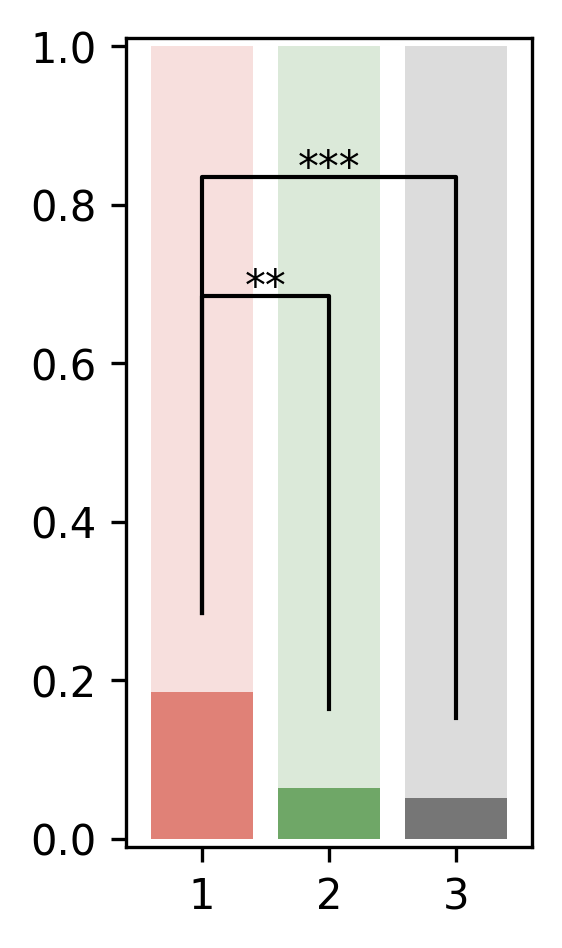

In [30]:
# bar plot of all clusters

bar_width = 0.8
colors = [red, darkgreen, darkgray]

nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

bar_pos = np.array([1,2,3])
tf_proportion = []
# cluster 1-3
tf_proportion.append(np.sum((tf_label_all==0)|(tf_label_all==1)|(tf_label_all==2))/np.sum((label_all==0)|(label_all==1)|(label_all==1)))
# cluster 4-5
tf_proportion.append(np.sum((tf_label_all==4)|(tf_label_all==5))/np.sum((label_all==4)|(label_all==5)))
# other than cluster 1-3
tf_proportion.append(np.sum((tf_label_all==-1)|(tf_label_all==4)|(tf_label_all==5))/np.sum((label_all==-1)|(label_all==4)|(label_all==5)))
tf_proportion = np.array(tf_proportion)
print(tf_proportion)
nontf_proportion = 1-tf_proportion

bars_low = ax.bar(bar_pos, tf_proportion,
                  width = bar_width,
                  color=colors, alpha=0.8)
bars_upper = ax.bar(bar_pos, nontf_proportion,
                    width = bar_width,
                    bottom=tf_proportion, color=colors, alpha=0.2)

ax.set_xlim(0.4,3.6)
ax.set_ylim(-0.01, 1.01)
ax.set_xticks(bar_pos, bar_pos)

# pv
hgap_big = 0.5
hgap_small = 0.01
hgap_txt = 0.1
for j, p in enumerate(p12[:]):
    x1 = 1
    x2 = x1+1
    bar1_max = tf_proportion[0]
    bar2_max = tf_proportion[1]
    bar12_max = np.maximum(bar1_max, bar2_max)

    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_txt, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_txt],
            lw=1,
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')

# pv
hgap_big = 0.65
hgap_small = 0.01
hgap_txt = 0.1
for j, p in enumerate(p13[:]):
    x1 = 1
    x2 = x1+2
    bar1_max = tf_proportion[0]
    bar2_max = tf_proportion[2]
    bar12_max = np.maximum(bar1_max, bar2_max)

    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_txt, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_txt],
            lw=1,
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')

plt.savefig(f'figs/fig_TF_all.pdf', dpi=300, bbox_inches='tight')